# Email Spam / Phishing Detection System

This notebook implements an **Email Spam / Phishing Detection System** using a multi‑agent architecture. It follows your CN7050-style structure with clear sections, agents in separate cells, and short markdown descriptions for each agent. You can use it directly in Google Colab or Jupyter.

## 1. Setup & Imports

In [1]:
import sys

# Check if running in Google Colab
if 'google.colab' in sys.modules:
    %pip install pandas scikit-learn matplotlib

In [2]:
"""Import core libraries for data handling, modelling and evaluation."""
import io
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import itertools

try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print(f"Running in Colab: {IN_COLAB}")

Running in Colab: True


## 2. Data Ingestion (Interactive Upload)

In this section you will **upload two CSV files**:

- One containing **spam/phishing emails**
- One containing **legitimate (non-spam) emails**

Each CSV should at minimum contain a column named `text` with the full email text (you can pre-concatenate subject and body before export if you like).

In [3]:
import io

"""Upload spam and legitimate email CSV files.

In Colab, you will be prompted twice:
1. Upload your SPAM/PHISHING CSV (e.g., spam_emails.csv)
2. Upload your LEGITIMATE CSV (e.g., legit_emails.csv)
"""

if IN_COLAB:
    print("Please upload your **SPAM / PHISHING** emails CSV (e.g., spam_emails.csv)...")
    uploaded_spam = files.upload()
    spam_filename = list(uploaded_spam.keys())[0]
    spam_df = pd.read_csv(io.BytesIO(uploaded_spam[spam_filename]))

    print("\nPlease upload your **LEGITIMATE (HAM)** emails CSV (e.g., legit_emails.csv)...")
    uploaded_legit = files.upload()
    legit_filename = list(uploaded_legit.keys())[0]
    legit_df = pd.read_csv(io.BytesIO(uploaded_legit[legit_filename]))
else:
    # Fallback if not in Colab – edit the paths below to point to your CSVs
    spam_path = "./spam_emails.csv"      # TODO: update path
    legit_path = "./legit_emails.csv"    # TODO: update path
    spam_df = pd.read_csv(spam_path)
    legit_df = pd.read_csv(legit_path)

# Create a 'text' column by concatenating 'subject' and 'body'
spam_df['text'] = spam_df['subject'].fillna('') + ' ' + spam_df['body'].fillna('')
legit_df['text'] = legit_df['subject'].fillna('') + ' ' + legit_df['body'].fillna('')

print("Spam / phishing dataset shape:", spam_df.shape)
print("Legitimate dataset shape:", legit_df.shape)

spam_df.head()

Please upload your **SPAM / PHISHING** emails CSV (e.g., spam_emails.csv)...


Saving SpamAssasin.csv to SpamAssasin.csv

Please upload your **LEGITIMATE (HAM)** emails CSV (e.g., legit_emails.csv)...


Saving CEAS_08.csv to CEAS_08.csv
Spam / phishing dataset shape: (5809, 8)
Legitimate dataset shape: (39154, 8)


,sender,receiver,date,subject,body,label,urls,text
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,"Thu, 22 Aug 2002 18:26:25 +0700",Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0,1,"Re: New Sequences Window Date: Wed, 21 ..."
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...","Thu, 22 Aug 2002 12:46:18 +0100",[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,1,[zzzzteana] RE: Alexander Martin A posted:\nTa...
2,"""Tim Chapman"" <timc@2ubh.com>",zzzzteana <zzzzteana@yahoogroups.com>,"Thu, 22 Aug 2002 13:52:38 +0100",[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,0,1,[zzzzteana] Moscow bomber Man Threatens Explos...
3,Monty Solomon <monty@roscom.com>,undisclosed-recipient: ;,"Thu, 22 Aug 2002 09:15:25 -0400",[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,0,1,[IRR] Klez: The Virus That Won't Die Klez: Th...
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,zzzzteana@yahoogroups.com,"Thu, 22 Aug 2002 14:38:22 +0100",Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi...",0,1,Re: [zzzzteana] Nothing like mama used to make...


### DataIngestionAgent
Loads and combines spam/phishing and legitimate email datasets into a single labelled dataframe.

In [4]:
class DataIngestionAgent:
    """Loads and combines spam/phishing and legitimate email datasets."""

    def __init__(self, spam_df: pd.DataFrame, legit_df: pd.DataFrame,
                 text_column: str = "text"):
        self.spam_df = spam_df.copy()
        self.legit_df = legit_df.copy()
        self.text_column = text_column

    def build_master_dataset(self) -> pd.DataFrame:
        # Add labels
        self.spam_df["label"] = "spam"
        self.legit_df["label"] = "legit"

        # Keep only text and label
        spam_clean = self.spam_df[[self.text_column, "label"]].dropna()
        legit_clean = self.legit_df[[self.text_column, "label"]].dropna()

        df = pd.concat([spam_clean, legit_clean], ignore_index=True)
        df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
        print(f"Combined dataset shape: {df.shape}")
        print(df["label"].value_counts())
        return df


# Instantiate and build the master dataset
ingestion_agent = DataIngestionAgent(spam_df=spam_df, legit_df=legit_df, text_column="text")
master_df = ingestion_agent.build_master_dataset()
master_df.head()

Combined dataset shape: (44963, 2)
label
legit    39154
spam      5809
Name: count, dtype: int64


,text,label
0,Your chixxxx can never forget these wonderful ...,legit
1,"[ILUG-Social] Tim O'Reilly, Bill Gates and Edg...",spam
2,"Re: kurila 1.3 released On 0, Gerard Goossen ...",legit
3,"Beautiful quartz, water-resistant Replica Watc...",legit
4,Re: [Python-3000] zlib.crc32 - signed or unsig...,legit


### PreprocessingAgent
Cleans and normalises raw email text (lowercasing, removing URLs, numbers and extra whitespace).

In [5]:
import re

class PreprocessingAgent:
    """Cleans raw email text for modelling."""

    URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")
    HTML_TAG_PATTERN = re.compile(r"<.*?>")

    def clean_text(self, text: str) -> str:
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = re.sub(self.URL_PATTERN, " URL ", text)
        text = re.sub(self.HTML_TAG_PATTERN, " ", text)
        text = re.sub(r"[^a-zA-Z@]+", " ", text)
        text = re.sub(r"\s+", " ", text).strip()
        return text

    def apply(self, df: pd.DataFrame, text_column: str = "text") -> pd.DataFrame:
        df = df.copy()
        df["clean_text"] = df[text_column].apply(self.clean_text)
        print("Sample cleaned text:")
        print(df[[text_column, "clean_text"]].head())
        return df


preprocessing_agent = PreprocessingAgent()
processed_df = preprocessing_agent.apply(master_df, text_column="text")

Sample cleaned text:
                                                text  \
0  Your chixxxx can never forget these wonderful ...   
1  [ILUG-Social] Tim O'Reilly, Bill Gates and Edg...   
2  Re: kurila 1.3 released On  0, Gerard Goossen ...   
3  Beautiful quartz, water-resistant Replica Watc...   
4  Re: [Python-3000] zlib.crc32 - signed or unsig...   

                                          clean_text  
0  your chixxxx can never forget these wonderful ...  
1  ilug social tim o reilly bill gates and edgar ...  
2  re kurila released on gerard goossen wrote kur...  
3  beautiful quartz water resistant replica watch...  
4  re python zlib crc signed or unsigned christia...  


### FeatureEngineeringAgent
Converts cleaned email text into numerical features using TF‑IDF vectorisation.

In [6]:
class FeatureEngineeringAgent:
    """Transforms text into TF‑IDF features."""

    def __init__(self, max_features: int = 10000, ngram_range=(1, 2)):
        self.vectorizer = TfidfVectorizer(max_features=max_features,
                                          ngram_range=ngram_range,
                                          sublinear_tf=True)

    def fit_transform(self, texts: pd.Series):
        X = self.vectorizer.fit_transform(texts)
        print("TF‑IDF matrix shape (train):", X.shape)
        return X

    def transform(self, texts: pd.Series):
        X = self.vectorizer.transform(texts)
        print("TF‑IDF matrix shape (test):", X.shape)
        return X


feature_agent = FeatureEngineeringAgent(max_features=10000, ngram_range=(1, 2))

# Train/validation split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    processed_df["clean_text"],
    processed_df["label"],
    test_size=0.2,
    random_state=42,
    stratify=processed_df["label"],
)

X_train = feature_agent.fit_transform(X_train_text)
X_test = feature_agent.transform(X_test_text)

TF‑IDF matrix shape (train): (35970, 10000)
TF‑IDF matrix shape (test): (8993, 10000)


### ModelTrainingAgent
Trains a baseline classifier (Logistic Regression) to distinguish between spam/phishing and legitimate emails.

In [7]:
class ModelTrainingAgent:
    """Trains a logistic regression classifier for spam/phishing detection."""

    def __init__(self):
        self.model = LogisticRegression(max_iter=1000, n_jobs=-1)

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        print("Model training complete.")
        return self.model


training_agent = ModelTrainingAgent()
model = training_agent.train(X_train, y_train)

Model training complete.


### EvaluationAgent
Evaluates the trained model using accuracy, a classification report and a confusion matrix.


Classification Report:

              precision    recall  f1-score   support

       legit       0.98      1.00      0.99      7831
        spam       0.98      0.83      0.90      1162

    accuracy                           0.98      8993
   macro avg       0.98      0.91      0.94      8993
weighted avg       0.98      0.98      0.98      8993

Confusion Matrix (raw counts):
[[7812   19]
 [ 197  965]]


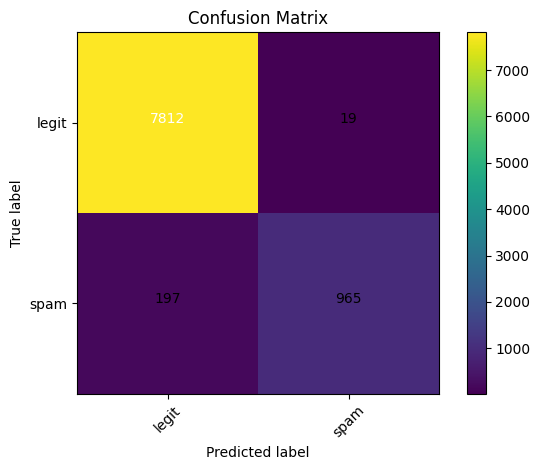

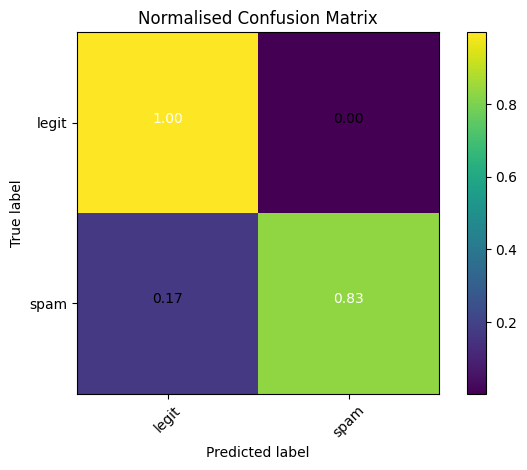

In [8]:
class EvaluationAgent:
    """Evaluates model performance on a held‑out test set."""

    def __init__(self, class_names):
        self.class_names = list(class_names)

    def plot_confusion_matrix(self, cm, normalize=False):
        """Plots a confusion matrix using matplotlib (no custom colours)."""
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            title = 'Normalised Confusion Matrix'
        else:
            title = 'Confusion Matrix'

        plt.figure()
        plt.imshow(cm)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(self.class_names))
        plt.xticks(tick_marks, self.class_names, rotation=45)
        plt.yticks(tick_marks, self.class_names)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

    def evaluate(self, model, X_test, y_test):
        y_pred = model.predict(X_test)
        print("\nClassification Report:\n")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred, labels=self.class_names)
        print("Confusion Matrix (raw counts):")
        print(cm)
        self.plot_confusion_matrix(cm, normalize=False)
        self.plot_confusion_matrix(cm, normalize=True)


class_names = sorted(processed_df["label"].unique())
evaluation_agent = EvaluationAgent(class_names=class_names)
evaluation_agent.evaluate(model, X_test, y_test)

### InferenceAgent
Provides a simple interface to classify new email text as spam/phishing or legitimate.

In [9]:
class InferenceAgent:
    """Wraps preprocessing, feature extraction and model prediction for new emails."""

    def __init__(self, preprocessing_agent: PreprocessingAgent,
                 feature_agent: FeatureEngineeringAgent,
                 model: LogisticRegression):
        self.preprocessing_agent = preprocessing_agent
        self.feature_agent = feature_agent
        self.model = model

    def predict(self, email_text: str) -> str:
        cleaned = self.preprocessing_agent.clean_text(email_text)
        X = self.feature_agent.transform(pd.Series([cleaned]))
        pred = self.model.predict(X)[0]
        proba = None
        if hasattr(self.model, "predict_proba"):
            proba = self.model.predict_proba(X).max()
        return pred, proba


inference_agent = InferenceAgent(preprocessing_agent, feature_agent, model)

# Quick demo on a few handcrafted examples
example_emails = [
    "Congratulations! You have won a $1000 gift card. Click here to claim now.",
    "Dear user, your mailbox storage is almost full. Please update your account information.",
    "Hi team, please find attached the minutes from today’s meeting.",
    "Security alert: unusual sign-in attempt detected on your account. Log in to verify your identity.",
]

for text in example_emails:
    label, proba = inference_agent.predict(text)
    print("\nEmail:", text)
    print("Predicted label:", label, " | Confidence:", proba)

TF‑IDF matrix shape (test): (1, 10000)

Email: Congratulations! You have won a $1000 gift card. Click here to claim now.
Predicted label: legit  | Confidence: 0.5268721153490961
TF‑IDF matrix shape (test): (1, 10000)

Email: Dear user, your mailbox storage is almost full. Please update your account information.
Predicted label: legit  | Confidence: 0.9924764954739923
TF‑IDF matrix shape (test): (1, 10000)

Email: Hi team, please find attached the minutes from today’s meeting.
Predicted label: legit  | Confidence: 0.9935773589032434
TF‑IDF matrix shape (test): (1, 10000)

Email: Security alert: unusual sign-in attempt detected on your account. Log in to verify your identity.
Predicted label: legit  | Confidence: 0.9663787873831429


### CoordinatorAgent
Coordinates the full pipeline from raw CSVs to evaluation. This is mainly for clarity and future extension.

In [10]:
class CoordinatorAgent:
    """Coordinates ingestion, preprocessing, feature engineering, training and evaluation."""

    def __init__(self, ingestion_agent, preprocessing_agent,
                 feature_agent, training_agent, evaluation_agent):
        self.ingestion_agent = ingestion_agent
        self.preprocessing_agent = preprocessing_agent
        self.feature_agent = feature_agent
        self.training_agent = training_agent
        self.evaluation_agent = evaluation_agent

    def run_pipeline(self):
        df = self.ingestion_agent.build_master_dataset()
        df_processed = self.preprocessing_agent.apply(df, text_column="text")

        X_train_text, X_test_text, y_train, y_test = train_test_split(
            df_processed["clean_text"],
            df_processed["label"],
            test_size=0.2,
            random_state=42,
            stratify=df_processed["label"],
        )

        X_train = self.feature_agent.fit_transform(X_train_text)
        X_test = self.feature_agent.transform(X_test_text)

        model = self.training_agent.train(X_train, y_train)
        self.evaluation_agent.evaluate(model, X_test, y_test)
        return model


coordinator_agent = CoordinatorAgent(
    ingestion_agent=ingestion_agent,
    preprocessing_agent=preprocessing_agent,
    feature_agent=feature_agent,
    training_agent=training_agent,
    evaluation_agent=evaluation_agent,
)

print("CoordinatorAgent is initialised. You can re-run the full pipeline with:")
print("model = coordinator_agent.run_pipeline()")

CoordinatorAgent is initialised. You can re-run the full pipeline with:
model = coordinator_agent.run_pipeline()


Combined dataset shape: (44963, 2)
label
legit    39154
spam      5809
Name: count, dtype: int64
Sample cleaned text:
                                                text  \
0  Your chixxxx can never forget these wonderful ...   
1  [ILUG-Social] Tim O'Reilly, Bill Gates and Edg...   
2  Re: kurila 1.3 released On  0, Gerard Goossen ...   
3  Beautiful quartz, water-resistant Replica Watc...   
4  Re: [Python-3000] zlib.crc32 - signed or unsig...   

                                          clean_text  
0  your chixxxx can never forget these wonderful ...  
1  ilug social tim o reilly bill gates and edgar ...  
2  re kurila released on gerard goossen wrote kur...  
3  beautiful quartz water resistant replica watch...  
4  re python zlib crc signed or unsigned christia...  
TF‑IDF matrix shape (train): (35970, 10000)
TF‑IDF matrix shape (test): (8993, 10000)
Model training complete.

Classification Report:

              precision    recall  f1-score   support

       legit       0.98 

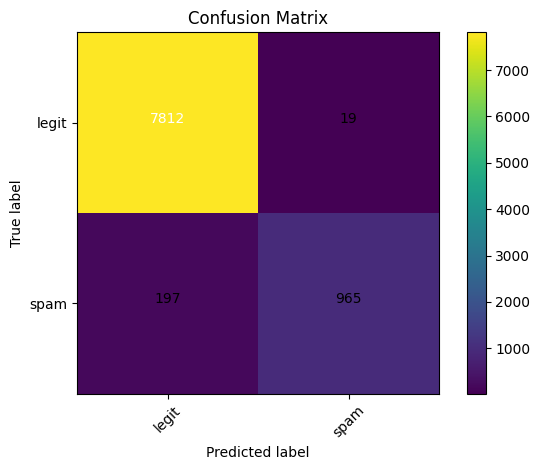

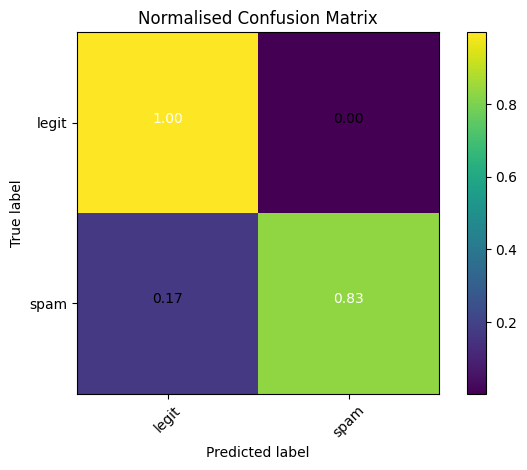

In [11]:
model = coordinator_agent.run_pipeline()

## 3. Next Steps & Customisation

- You can **swap the model** (e.g., use `LinearSVC` or another classifier) inside `ModelTrainingAgent`.
- You can **extend labels** to include a dedicated `phishing` class if your CSVs are multi‑label.
- You can **export the trained model and vectoriser** using `joblib` for integration into a web or API front‑end.
- In your CN7050 report, you can treat each Agent as a separate component in your system architecture / UML diagrams.